# Show me your plate and I tell you who you are

#### The Notebook is organized into multiple sub-section with different focal points, for ease of navigation, you can click on one of the links and we will take you there! Based on compatibility issues, we have seperate Notebooks for some GeoVizualization, as well as data aquisition and rough merging of the geodata based on package conflicts and single-use in our processing pipeline

- <a href='#DataLoading'>Data Loading, Cleaning and Joining</a>
- <a href='#Clustering'>Clustering</a>
- <a href='#WorkFlow'>Workflow and Factory Definition</a>
- <a href='#Stats'>Statistical Analysis</a>
- <a href='#Ensemble'>Ensemble Models</a>
- <a href='#AssociationRule'>Association Rule Mining</a>
- <a href='#DecisionTree'>Decision Tree Mining</a>
- <a href='#GeoViz'>GeoViz</a>



#### Unified Package Loading Prelude

In [6]:
# Ever Greens
import pickle as pkl 
import pandas as pd 
import numpy as np 
import statsmodels as sml
import math 
from scipy import stats

# Plotly Package
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.io as pio
from plotly.subplots import make_subplots

### Association Rule Mining Packags
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule

# Stats Model Package
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Sklearn Package
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# DataViz Packages
from dtreeviz.trees import dtreeviz 
import matplotlib.pyplot as plt
import seaborn as sns

# Tool Packages
from tqdm import tqdm
import os 
import itertools as it 
from pathlib import Path
import glob
import json
import geojson
from urllib.request import urlopen
from IPython.display import IFrame

py.init_notebook_mode(connected=True)

pio.renderers.default='notebook'

## Defining Helper Functions and Factories for later usage

<a id='WorkFlow'></a>

#### Doing what the Kids nowadays call a Pro-Gamer Move

In [7]:
# Calling Systems Command in a Jupyter Notebook (Trust me I am an Engineer)
def github_hook():
    print("Hello, ... Hello, ... Vienna Calling?")
    %cd -q ../fierceeagle.github.io/
    # Adds the Plot if new Name
    print("Adding new Files ...")
    !git add *.html
    print("Commiting Changes ...")
    !git commit -m"Added/Changed Plot" --quiet
    print("Pulling previous Changes ... ")
    !git pull --quiet
    print("Pushing to Remote...")
    !git push --quiet
    print("Finished")
    print("Rock me Amadeus")
    %cd -q ../ada-2020-project-milestone-p3-p3_binging_with_babbage/
    

In [8]:
def plot_map_inline(path, display_width = 1280, display_height = 720):
    return IFrame(src = path, width = display_width, height = display_height)

#### Doing an inverse Margaret Thatcher (Not reviving Irish though)

In [9]:
# Simple adaptable Model Pipeline Factory
def pipeline_factory(scaler, model, x_train, y_train, verbose = True):
    
    pipeline = Pipeline(steps = [
        ('scaler',  scaler),
        ('regressor',   model)
        ], verbose = verbose)
        
    pipeline.fit(x_train,y_train)
    return pipeline


In [10]:
# Generates Correlation Bar plots for different input parameters
# Returns a Fig and can optionally automaically write to the Website HTML Plot Repo. (Automatic Commit, Pull, Push and Deployment WIP) 
# Still need to Add Plot to index.md in later case, for it to show.

def bar_plot_factory(dataframe,category_socio_economics, category_nutrion, html_name = "", output_html = False, auto_commit = False):
    
    # Make a double column plot for more than 3 categories
    if len(category_socio_economics) > 3:
        cols = 2 
        rows = math.ceil(len(category_socio_economics)/2)
    else:
        cols = len(category_socio_economics)
        rows = 1
    
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=([label_processor(x) for x in category_socio_economics]))
                                                             
    for cat_soc, index in zip(category_socio_economics, it.product(range(1, rows + 1), range(1, cols + 1))) :
       
        correl = [(nutr, stats.spearmanr(a = dataframe[cat_soc], b = dataframe[nutr]).correlation) for nutr in category_nutrion if stats.spearmanr(a = dataframe[cat_soc], b = dataframe[nutr]).pvalue < 0.05]

        fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] >= 0], y=[c[1] for c in correl if c[1] >= 0],
                            marker_color= color_tesco_blue,
                            name='positives'), row = index[0], col = index[1])

        fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] < 0], y=[c[1] for c in correl if c[1] < 0],
                            marker_color= color_tesco_red,
                            name='negatives'), row = index[0], col = index[1])
    
        fig.update_layout(template = "plotly_white", showlegend=False)
        
    path = "../fierceeagle.github.io/_includes/"+ html_name+".html"
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html(path)
        print("Ave Imperator, morituri te salutant")
        
        if auto_commit: 
            github_hook()
            
    return plot_map_inline(path)

In [11]:
# Genrates an interactive 3D Plot and generate an HTML 
def three_D_plot_factory(dataframe,x_axis, y_axis, z_axis,quantiles, aggfunc, title = "", x_title ="",  y_title = "", z_title = "", html_name = "",imputer_n = 3, output_html = False, auto_commit = False):
    
    slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
    slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
    slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
    pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)
    
    # Using an KNN Imputer with a given aggregationfunction to impute missing value, in case of the curretn quantiles just one value is missing. 
    imputer = KNNImputer(n_neighbors=imputer_n)
    pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
    fig = go.Figure(
        data=go.Surface(z=pivot_slice_df.values),
            layout=go.Layout(
            ))

    fig.update_layout(
            title=title,
            scene = dict(
                        xaxis = dict(
                            title = x_title,
                            nticks = len(pivot_slice_df.columns.tolist()),
                            tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                            ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()]),
                        yaxis = dict(
                            title = y_title,
                            nticks = len(pivot_slice_df.index.tolist()),
                            tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                            ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()]),
                        zaxis_title= z_title),
                        margin=dict(r=40, b=40, l=40, t=40)
            )
    
    path = "../fierceeagle.github.io/_includes/"+ html_name+".html"
    fig.update_layout(showlegend=False)
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html(path)
        print("Ave Imperator, morituri te salutant")
        
        if auto_commit: 
            github_hook()
    
    return plot_map_inline(path)

In [12]:
# Genrates an interactive 3D Plot and generate an HTML 
def three_D_multi_plot_factory(dataframe,x_axis, y_axis, category_z ,quantiles, aggfunc, title = "", x_title ="",  y_title = "", z_title = ["",""], imputer_n = 3, html_name = "", output_html = False, auto_commit = False):
    
    if len(category_z) > 3:
        cols = 2 
        rows = math.ceil(len(category_z)/2)
        specs = [[{'is_3d': True},{'is_3d': True}] for x in range(rows)]
    else:
        cols =  len(category_z)
        rows =  1
        specs = [[{'is_3d': True} for x in range(cols)]]
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=([label_processor(x)for x in category_z]), specs= specs, shared_xaxes = True, shared_yaxes = True, horizontal_spacing = 0.35)

    for z_axis, index in zip(category_z, it.product(range(1, rows + 1), range(1, cols + 1))) :
        slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
        slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
        slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
        pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)

        imputer = KNNImputer(n_neighbors=imputer_n)
        pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
        
        fig.add_trace(go.Surface(
                      z  = pivot_slice_df.values,
                      showlegend= False,
                      showscale=False,
                      ),row = index[0], col = index[1])
            
    fig.update_layout(title=title)
    fw=go.FigureWidget(fig)
    
    camera = dict(eye=dict(x=-2.25, y=-2.25, z=0.5))
    
    # So akward, but works better than everything else I tried.
    with fw.batch_update():
        for x in range(1,len(category_z)+1):
            fw.layout["scene" + str(x)] = scene = dict(
                                              camera = camera,
                                              xaxis = dict(
                                                title = dict(text = x_title, font = dict(family =  'Arial', size = 10, color = '#7f7f7f')),
                                                nticks = len(pivot_slice_df.columns.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                                                ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()],
                                                tickfont = dict(family =  'Arial', size = 8, color = '#7f7f7f')),
                                              yaxis = dict(
                                                title = dict(text = y_title, font = dict(family =  'Arial', size = 10, color = '#7f7f7f')),
                                                nticks = len(pivot_slice_df.index.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                                                ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()],
                                                tickfont = dict(family =  'Arial', size = 8, color = '#7f7f7f')),
                                              zaxis_title = dict(text = z_title, font = dict(family =  'Arial', size = 10, color = '#7f7f7f'))) 
              
    path = "../fierceeagle.github.io/_includes/"+ html_name+".html"           
    if output_html:
        print("Writing HTML to Repo...")
        fw.write_html(path)
        print("Ave Imperator, morituri te salutant")
        
        
        if auto_commit: 
            github_hook()
            
    return plot_map_inline(path)

In [13]:
# Creates Choropleth Maps and displays them in the Notebook using Inline HTML

def map_plot_factory(data, geojson, color_col, labels, file_name, hook = False,opacity = 0.35, zoom = 9):
    print("Generating Map ... ")
    map_fig = px.choropleth_mapbox( data, 
                                    geojson=msoa_dict, 
                                    locations=data.index, 
                                    mapbox_style="carto-positron",
                                    color= color_col,
                                    zoom=zoom, center = {"lat": 51.509865, "lon": -0.118092},
                                    opacity=opacity,
                                    labels=labels
                                  )
    
    map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    
    print("Updating Layout ... ")
    
    # Anchors Legend over the Map
    map_fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="right",
                            x=0.99
                        ))

    print("Writing HTML ...")

    # Create the HTML and Write it to the File specified in path
    html = py.plot(map_fig, auto_open=False, output_type='div')
    path = "./../fierceeagle.github.io/_includes/" + file_name + ".html"
    with open(path, 'w') as file:
        file.write(html)
    
    if hook:
        print("Call me Ishmael")
        github_hook()
    
    # Call the Jupyter Notebook IFrame HTML
    print("Creating IFrame ...")
    return plot_map_inline(path)
    

In [14]:
# Creates Choropleth Maps and displays them in the Notebook using Inline HTML

def multilayer_map_plot_factory(data, geojson, file_name,title , layers, hovertemplate = "" , hook = False,opacity = 0.35, zoom = 9):
    print("Generating Map ... ")
    
    fig_layers = []
    LE = LabelEncoder()
  
    map_fig = go.Figure()
    
    for layer in layers:
        fig_layers.append(go.Choroplethmapbox(
                geojson=geojson,
                locations=data.index,
                z= LE.fit_transform(data[layer]),
                hovertemplate=hovertemplate + "<extra></extra>",
                showscale=False,
                visible=False,
                colorscale = px.colors.qualitative.T10
            ))
        
    
    fig_layers[0]["visible"] = True
    
    
    
    print("Updating Layout ... ")
    

    show_layers = []
    template_visibility = np.zeros((len(layers),)).astype(bool)
    for i in range(len(layers)):
        visibility = list(np.copy(template_visibility))
        visibility[i] = True
        show_layers.append(visibility)
    
    buttons = []
    for i , layer in enumerate(layers):
        buttons.append({
            'args': ['visible', show_layers[i]],
            'label': layer,
            'method': 'restyle'
        })
        
    layout = go.Layout(
        title=title,
        font={'family': 'Arial'},
        mapbox_zoom=zoom,
        mapbox_style="carto-positron",
        mapbox_center={"lat": 51.509865, "lon": -0.118092},
        margin={'r': 0, 'l': 50, 't': 50, 'b': 0}
    )
    
    layout.update(
        updatemenus=[{
            'x': 0.95,
            'y': 0.95,
            'yanchor': 'top',
            'buttons': buttons
        }],
        legend=dict(
                            yanchor="top",
                            y=0.95,
                            xanchor="left",
                            x=0.01
                        )
    )
    
    
   
    mutli_layer_fig = go.Figure(data=fig_layers, layout=layout)
    
    mutli_layer_fig.update_traces(marker=dict(opacity = opacity))
    
    print("Writing HTML ...")
    
    # Create the HTML and Write it to the File specified in path
    html = py.plot(mutli_layer_fig, auto_open=False, output_type='div')
    path = "./../fierceeagle.github.io/_includes/" + file_name + ".html"
    with open(path, 'w') as file:
        file.write(html)
    
    if hook:
        print("Call me Ishmael")
        github_hook()
    
    # Call the Jupyter Notebook IFrame HTML
    print("Creating IFrame ...")
    return plot_map_inline(path)
    


In [180]:
## Creates a Tree Plot using the dtreeviz libary, can automatically write the resulting SVG to a file and push the local repo, however need to consider to change the width and height parameter of the svg

def tree_plot_factory(X, y, X_cols, y_col, clf, reverse_dict, store_tree = False, path = "./../fierceeagle.github.io/_includes/", file_name = "place_holder", hook = False):
    
    y = y.apply(lambda x : reverse_dict[x])
    
    # Fitting the Data, for later visualization
    clf.fit(X,y)    
    viz = dtreeviz(clf, X, y,
                   target_name= y_col,
                   feature_names= X_cols,
                   class_names= list(reverse_dict.keys())
        )  

    if store_tree:
        print("Storing SVG")
        viz.save(path + file_name + ".svg")
        print("For Website usage, open the final Image and remove the height parameter \n and set the width to 100% so it scales on the website")
    
    if hook: 
        github_hook()
        
    return viz

### ML Helper Functions, performing Grid Search 

In [207]:
def post_pruning_decision_tree_selector(X_data, y_data, parameters, cv = 20, scoring = "accuracy"):

    gsCV = GridSearchCV(DecisionTreeClassifier(random_state=0),parameters, cv = cv, scoring=scoring, n_jobs=-1)
    gsCV.fit(X_data,y_data)
    
    clf = gsCV.best_estimator_
    print ("Best GridSeach Score: ", gsCV.best_score_, "Best Parameter Combination: ", gsCV.best_params_)
    
    return clf, gsCV.best_score_, gsCV.best_params_


#### Defining some support functions making all the String Processing we need once and never again

In [15]:
## Process a column Label to Look nice in a Plot
def label_processor(label): 
    
    # eth columns
    if "ethnicity" in label:
        label = label.split("ethnicity_")[1].replace("_2011", "").capitalize()
        
        if "Bame" in label: 
            label = label.replace("Bame", "BAME")
        if "Other" in label:
            label = label.replace("Other", "Other Ethnicites")
        
    # edu columns
    elif "qualification" in label:
        label = label.replace("qualification_", "", 1).replace("_2011", "").replace("_", " ").capitalize() 
        
        if "Level" in label:
            label = label + " Qualification"
    # income columns  
    elif "annual" in label: 
        label = label.split("annual_")[1].replace("_", " ").capitalize()
        
    elif label in nutrients:
        label = label.split("_")[1].capitalize()
        
    elif label in products:
        label = " ".join([x.capitalize() for x in label.replace("f_", "").split("_")])
    
    elif "Religion" in label:
        label = label.split("_")[1]
    
    elif "Income" in label:
        label = label.split("_")[1]
        
    elif "Ethnicity" in label:
        label = label.split("_")[1]
           
    elif "Education" in label:
        label = label.split("_")[1]
           
    
    return label    

In [16]:
# Generating the new column names using Lucas 
def get_cleaned_column_names(df, is_ward = False):
    
    year_strings = range(1990,2021)
    year_strings = [str(val) for val in year_strings]

    ethnic_groups = ["White","Mixed","Asian","Black","BAME", "Other"]

    ward_ethnic_groups_5 = ["White","Mixed","Asian or Asian British","Black or Black British","Other"]

    ward_ethnic_groups_18 = ["White British","White Irish","White Gypsy or Irish Traveller","Other White",
                             "Mixed White and Black Caribbean","Mixed White and Black African",
                             "Mixed White and Asian", "Other Mixed","Indian","Pakistani","Bangladeshi",
                             "Chinese","Other Asian","Black Caribbean","Black African","Other Black",
                             "Arab","Other Ethnic Group"]

    employment_types = ["Total","Employee","Self-employed","Unemployed","student"]

    qualifications = ["Level 1", "Level 2", "Level 3", "Level 4", "Apprenticeship", 
                      "No qualification","Other qualifications","students"]

    religions = ["Christian","Buddhist","Hindu","Jewish","Muslim","Sikh",
             "Other religion","No religion","Religion not stated"]
    
    income = ["Mean Annual","Median Annual"]

    dismiss_words = ["Population Estimates", "Density", "Health", "Transport", 
                     "Car or van", "Household Composition", "All households", "All Households", "Dwelling type", 
                     "Road Casualties","Tenure","Lone Parents", "Adults in Employment",
                     "Child Benefit", "Incidence of Cancer","Life Expectancy",
                     "Low Birth Weight Births","Obesity","Central Heating","Income Deprivation",
                     "Age Structure", "Mid-year Estimate", "Land Area", "Births and deaths",
                     "Population and Age","Home repossessions","Household composition","Number of properties sold",
                     "dwellings sold during year","Dwellings and Council tax","Property Type","Size of dwellings",
                     "Property build period", "Crime", "Ambulance","Childhood Obesity Prevalence", "Air Emissions",
                     "Land Use","Car access","Travel to work by bicycle","of LSOAs in worst","Nat Insurance",
                     "Election turnout","Workplace employment","Binge Drinking","A-Level Point Scores",
                     "Average GCSE capped","Pupil Absence","Out-of-Work Families","Fires","Access to green space and nature",
                     "Indices of Deprivation","Children in Poverty","Jobseekers Allowance","Benefits claimants",
                     "Happiness and Well-being","Lone Parent Not in Employment","Adults not in Employment"]

    new_col_names = []
    old_col_names = []

    for col_name in df.columns:
        new_name = ""
        for word in dismiss_words:
            if word in col_name:
                new_name += "YEET_"       
    
        # catch percentage
        if "%" in col_name or "(rates)" in col_name or "(Percentages)" in col_name:
            new_name += "perc_"
    
        # catch ethnic groups
        if "Ethnic Group" in col_name:
            new_name += "ethnicity_"
            if "5 groups" in col_name:
                new_name += "5_groups_"
                for group in ward_ethnic_groups_5:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
            if "18 groups" in col_name:
                new_name += "18_groups_"
                for group in ward_ethnic_groups_18:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
            if not is_ward:    
                for group in ethnic_groups:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
    
        # country of birth
        if "Country of Birth" in col_name:
            if "Not" in col_name:
                new_name += "not_uk_born_"
            else:
                new_name += "uk_born_"
    
        # languages
        if "Language" in col_name:
            new_name += "language_"
            if "at least one" in col_name:
                new_name += "has_+16_english_speaker_"
            else:
                new_name += "has_not_+16_english_speaker_"
    
        # religion
        if "Religion" in col_name:
            new_name += "religion_"
            for religion in religions:
                if religion in col_name:
                    new_name += religion.lower().replace(" ","_") + "_"
    
        # house prices
        if "House Prices" in col_name:
            if "Median" in col_name:
                new_name += "median_house_price_"
            elif "Sales" in col_name:
                new_name += "sales_house_price_"
        #income 
        if "Household Income" in col_name:
            if "Median" in col_name:
                new_name += "annual_median_income_"
            if "Mean" in col_name:
                new_name += "annual_mean_income_"
        
        # economic activity
        if "Economic Activity" in col_name:
            if is_ward:
                if "Economically active" in col_name:
                    new_name += "economically_active_"
                
                if "Employment rate" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "employment_rate_"
                if "In employment" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "in_employment_"
                if "Unemployed" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "unemployed_"
                    
                if "Economically Inactive" in col_name:
                    new_name += "economically_inactive_"
                
                if "24" in col_name:
                    new_name += "16_24_"
                if "64" in col_name:
                    new_name += "16_64_"
                if "74" in col_name:
                    new_name += "16_74_"    
            else:
                if "Employment Rate" in col_name:
                    new_name += "employment_rate_"
                elif "Unemployment Rate" in col_name:
                    new_name += "unemployment_rate_"
                else:    
                    new_name += "economic_activity_"
                    if "inactive" in col_name:
                        new_name += "inactive_total_"
                    else:
                        new_name += "active_"
                        for employment in employment_types:
                            if employment in col_name:
                                new_name += employment.lower().replace("-","_") + "_"
            
        # qualifications
        if "Qualifications" in col_name:
            new_name += "qualification_"
            for qualification in qualifications:
                if qualification in col_name:
                    new_name += qualification.lower().replace(" ","_") + "_"
        
        # appending the year
        for year in year_strings:
            if year in col_name:
                new_name += year
    
        if "Lower Super Output Area" == col_name:
            new_name = "lsoa_code"
        if "Middle Super Output Area" == col_name:
            new_name = "msoa_code"
        if "Names" == col_name:
            new_name = "name"
        if "MSOA Name" == col_name:
            new_name = "name"
        if "Unnamed: 1" == col_name:
            new_name = "ward_code"
        if "Unnamed: 2" == col_name or "Unnamed: 0" == col_name:
            new_name = "YEET"
        if "Unnamed: 3" == col_name:
            new_name = "name"
        
        if "YEET" not in new_name:
            old_col_names.append(col_name)
            new_col_names.append(new_name)
    
    return old_col_names, new_col_names

#### Defining a few interesing Slices for the DF to use

In [17]:
nutrients   = ["energy_fat", "energy_saturate", "energy_sugar", "energy_protein","energy_carb","energy_fibre", "energy_alcohol"]
ethnicities = ["perc_ethnicity_white_2011","perc_ethnicity_mixed_2011","perc_ethnicity_asian_2011","perc_ethnicity_black_2011","perc_ethnicity_other_2011","perc_ethnicity_bame_2011"]
religions   = ["perc_religion_christian_2011","perc_religion_buddhist_2011","perc_religion_hindu_2011","perc_religion_jewish_2011","perc_religion_muslim_2011","perc_religion_sikh_2011","perc_religion_other_religion_2011","perc_religion_no_religion_2011"]
products    = ["f_beer","f_dairy","f_eggs","f_fats_oils","f_fish","f_fruit_veg","f_grains","f_meat_red","f_poultry","f_readymade","f_sauces","f_soft_drinks","f_spirits","f_sweets","f_tea_coffee","f_water","f_wine"]
education   = ["qualification_no_qualification_2011","qualification_level_1_2011","qualification_level_2_2011","qualification_apprenticeship_2011","qualification_level_3_2011","qualification_level_4_2011","qualification_other_qualifications_2011","qualification_students_2011"]
months      = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [18]:
color_tesco_red = '#EE1C2E'
color_tesco_blue = '#00539F'

### Loading the Data
<a id='DataLoading'></a>

#### Loading the yearly Tesco Data

In [19]:
### Tesco Data
tesco_path = ("Tesco_Data")

lsoa_year     = pd.read_csv(os.path.join(tesco_path, "year_lsoa_grocery.csv"), index_col = "area_id")
msoa_year     = pd.read_csv(os.path.join(tesco_path, "year_msoa_grocery.csv"), index_col = "area_id")
osward_year   = pd.read_csv(os.path.join(tesco_path, "year_osward_grocery.csv"), index_col = "area_id")

#### Loading the monthly Tesco Data

In [20]:
# Why don't the name of months follow a lexographical ordering

lsoa_months   = pd.DataFrame()
msoa_months   = pd.DataFrame()
osward_months = pd.DataFrame()


for month in months: 
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_lsoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    lsoa_months        = lsoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_msoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    msoa_months        = msoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_osward_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    osward_months      = osward_months.append(loading)
    
lsoa_months["month"]   = pd.Categorical(lsoa_months['month'], categories=months, ordered=True)
msoa_months["month"]   = pd.Categorical(msoa_months['month'], categories=months, ordered=True)
osward_months["month"] = pd.Categorical(osward_months['month'], categories=months, ordered=True)

#### Loading the Socio-Economic Data

In [40]:
socio_path = ("Socio_Economic_Data")

raw_lsoa_df = pd.read_csv(os.path.join(socio_path,"lsoa-data.csv"),encoding='latin1')
raw_msoa_df = pd.read_csv(os.path.join(socio_path,"msoa-data.csv"),encoding='latin1')
raw_ward_df = pd.read_csv(os.path.join(socio_path,"ward-atlas-data.csv"),encoding='latin1')
raw_ward_df = raw_ward_df.drop(0)

#### Loading the GeoViz Data prepared by Luca

In [41]:
json_dump_path = "./geo/"
with open(json_dump_path + 'ward_geometry.json', 'r') as json_path:
    ward_dict = json.load(json_path)
with open(json_dump_path + 'msoa_geometry.json', 'r') as json_path:
    msoa_dict = json.load(json_path)
with open(json_dump_path + 'lsoa_geometry.json', 'r') as json_path:
    lsoa_dict = json.load(json_path)
    

#### Luca's Column Name Preparing and Cleaning Services 

In [42]:
ward_old_names, ward_new_names = get_cleaned_column_names(raw_ward_df, is_ward = True)
msoa_old_names, msoa_new_names = get_cleaned_column_names(raw_msoa_df)        
lsoa_old_names, lsoa_new_names = get_cleaned_column_names(raw_lsoa_df) 

ltd_raw_ward_df = raw_ward_df[ward_old_names]
ltd_raw_msoa_df = raw_msoa_df[msoa_old_names]
ltd_raw_lsoa_df = raw_lsoa_df[lsoa_old_names]

ward_name_dict = dict(zip(ward_old_names, ward_new_names))
msoa_name_dict = dict(zip(msoa_old_names, msoa_new_names))
lsoa_name_dict = dict(zip(lsoa_old_names, lsoa_new_names))

osward_social = ltd_raw_ward_df.rename(ward_name_dict,axis=1)
msoa_social = ltd_raw_msoa_df.rename(msoa_name_dict,axis=1)
lsoa_social = ltd_raw_lsoa_df.rename(lsoa_name_dict,axis=1)

# Drops higher Level Aggregation and NaN Rows
lsoa_social     = lsoa_social[lsoa_social["name"].notna()]
msoa_social     = msoa_social[msoa_social.msoa_code.notna()]
osward_social   = osward_social[osward_social["name"].apply(lambda x: True if x not in ["London", "England", "England and Wales"] else False)]

# Setting the index
lsoa_social = lsoa_social.set_index("lsoa_code")
msoa_social = msoa_social.set_index("msoa_code")
osward_social = osward_social.set_index("ward_code")

In [43]:
## Two LSOA are not accounted for in the Tesco dataset and will be dropped by the join
[x for x in lsoa_social.index if x not in lsoa_year.index]

['E01000328', 'E01003902']

## Clustering similar areas together, based on common socio-economic attributes
<a id='Clustering'></a>

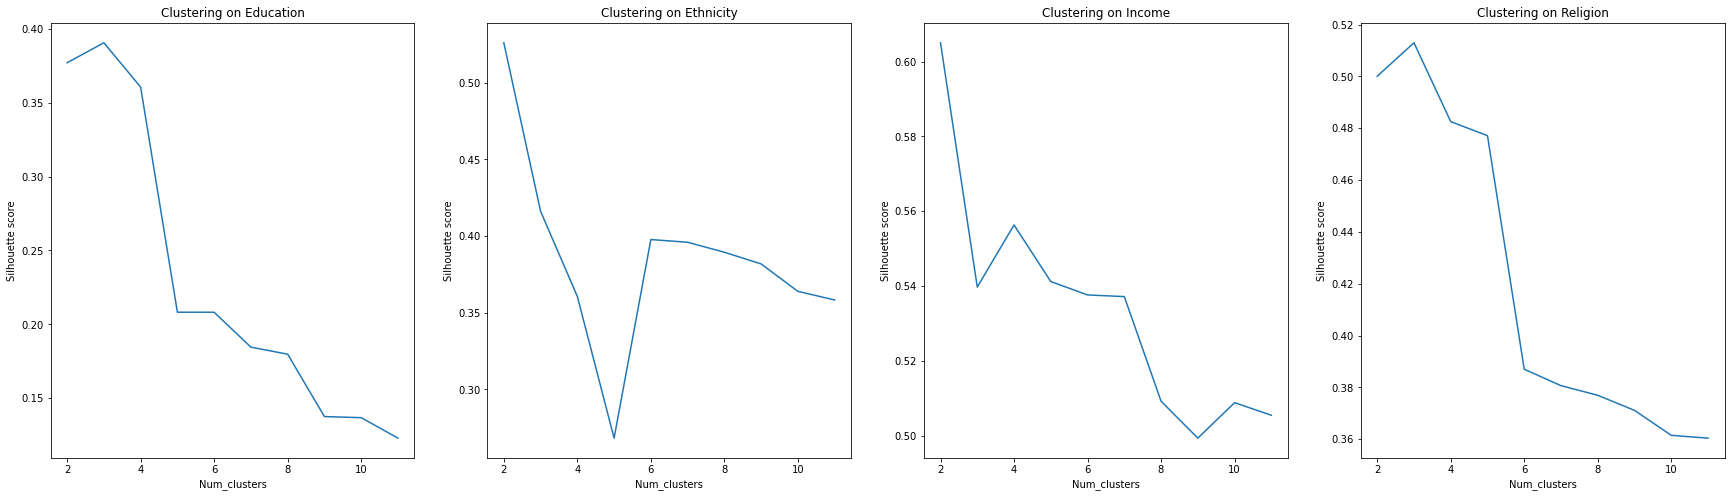

In [44]:
eth_complete = ["perc_ethnicity_white_2011","perc_ethnicity_mixed_2011","perc_ethnicity_asian_2011","perc_ethnicity_black_2011","perc_ethnicity_other_2011"]

msoa_cluster_eth = msoa_social[eth_complete]
msoa_cluster_edu = msoa_social[education]
msoa_cluster_inc = msoa_social["annual_median_income_2011"].values.reshape(-1,1)
msoa_cluster_rel = msoa_social[religions]

silhouettes_edu = []
silhouettes_eth = []
silhouettes_inc = []
silhouettes_rel = []


for k in range(2, 12):
    # Cluster the data and assigne the labels
    
    labels_edu = AgglomerativeClustering(n_clusters=k, affinity = "cosine", linkage = "average").fit_predict(msoa_cluster_edu)
    labels_eth = AgglomerativeClustering(n_clusters=k, affinity = "cosine", linkage = "average").fit_predict(msoa_cluster_eth)
    labels_inc = AgglomerativeClustering(n_clusters=k).fit_predict(msoa_cluster_inc)
    labels_rel = AgglomerativeClustering(n_clusters=k, affinity = "cosine", linkage = "average").fit_predict(msoa_cluster_rel)
    
    # Get the Silhouette score
    score_edu = silhouette_score(msoa_cluster_edu, labels_edu)
    score_eth = silhouette_score(msoa_cluster_eth, labels_eth)
    score_inc = silhouette_score(msoa_cluster_inc, labels_inc)
    score_rel = silhouette_score(msoa_cluster_rel, labels_rel)
    
    silhouettes_edu.append({"k": k, "score": score_edu})
    silhouettes_eth.append({"k": k, "score": score_eth})
    silhouettes_inc.append({"k": k, "score": score_inc})
    silhouettes_rel.append({"k": k, "score": score_rel})

# Convert to dataframe
silhouettes_edu = pd.DataFrame(silhouettes_edu)
silhouettes_inc = pd.DataFrame(silhouettes_inc)
silhouettes_eth = pd.DataFrame(silhouettes_eth)
silhouettes_rel = pd.DataFrame(silhouettes_rel)

# Plot the data

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (30,8))
ax1.plot(silhouettes_edu.k, silhouettes_edu.score)
ax2.plot(silhouettes_eth.k, silhouettes_eth.score)
ax3.plot(silhouettes_inc.k, silhouettes_inc.score)
ax4.plot(silhouettes_inc.k, silhouettes_rel.score)


ax1.set_xlabel("Num_clusters")
ax1.set_ylabel("Silhouette score")
ax1.set_title("Clustering on Education")

ax2.set_xlabel("Num_clusters")
ax2.set_ylabel("Silhouette score")
ax2.set_title("Clustering on Ethnicity")

ax3.set_xlabel("Num_clusters")
ax3.set_ylabel("Silhouette score")
ax3.set_title("Clustering on Income")

ax4.set_xlabel("Num_clusters")
ax4.set_ylabel("Silhouette score")
ax4.set_title("Clustering on Religion")

plt.show()

In [45]:
agg_clustering = AgglomerativeClustering(n_clusters = 6, affinity = "cosine", linkage = "average").fit(msoa_social[eth_complete])
msoa_social["Cluster_ethn"] = agg_clustering.labels_

agg_clustering = AgglomerativeClustering(n_clusters = 3, affinity = "cosine", linkage = "average").fit(msoa_social[education])
msoa_social["Cluster_edu"] = agg_clustering.labels_

agg_clustering = AgglomerativeClustering(n_clusters = 4).fit(msoa_social["annual_median_income_2011"].values.reshape(-1,1))
msoa_social["Cluster_inc"] = agg_clustering.labels_

agg_clustering = AgglomerativeClustering(n_clusters = 3, affinity = "cosine", linkage = "average").fit(msoa_social[religions])
msoa_social["Cluster_rel"] = agg_clustering.labels_


### Giving the Child a Name

For the education clustering, we can observe for the 3 Cluster that:

- Cluster 0 represent the highly educated middle and upper class, located in and around the Metropolitan Center of London and the Gentrified Areas in western London
- Cluster 1 represent students living in and around the different Campi inside and around London
- Cluster 2 represent the rest of the population in regard to lower to middle class inhabitants with a wider distribution of qualifications per-area

We rename these groupings those into Educated, Students and DAWSD

In [46]:
msoa_social[education + ["Cluster_edu"]].groupby(by = "Cluster_edu").median()

,qualification_no_qualification_2011,qualification_level_1_2011,qualification_level_2_2011,qualification_apprenticeship_2011,qualification_level_3_2011,qualification_level_4_2011,qualification_other_qualifications_2011,qualification_students_2011
Cluster_edu,,,,,,,,
0,811,492,614,70,662,3333,601,477
1,1028,638,625,67,1590,2248,698,2479
2,1355,840,889,119,679,1832,629,456


In [113]:
new_names_edu = {0:"Academic Degree", 1:"Students", 2:"Secondary School"}

msoa_social["Education"] = msoa_social["Cluster_edu"].apply(lambda x: new_names_edu[x])
msoa_social["Education"] = pd.Categorical(msoa_social["Education"], categories=["Academic Degree", "Students", "Secondary School"])

For the ethnicity clustering, we can observe for the 6 Cluster that:

- Cluster 0 represents areas with a small white majority and a strong asian minority
- Cluster 1 represents areas with a asian majority
- Cluster 2 represents areas with a black majority and also a significant white minority
- Cluster 3 represents areas with an equal represenatation of the three largests groups, white, asian and black. 
- Cluster 4 represents areas with a small white majority and a strong black minority
- Cluster 5 represents areas with a strong white majoirty

We rename these groupings those into Educated, Students and DAWSD

In [114]:
msoa_social[eth_complete + ["Cluster_ethn"]].groupby(by = "Cluster_ethn").median()

,perc_ethnicity_white_2011,perc_ethnicity_mixed_2011,perc_ethnicity_asian_2011,perc_ethnicity_black_2011,perc_ethnicity_other_2011
Cluster_ethn,,,,,
0,51.6,4.7,29.00,9.80,3.30
1,27.8,3.6,53.40,9.85,3.55
2,37.1,7.0,10.20,41.30,4.10
3,31.9,5.8,32.75,24.85,3.50
4,51.8,6.9,10.50,24.90,3.20
5,75.4,4.5,9.70,5.70,2.00


In [115]:
new_names_ethn = {0:"Strong Asian Minority", 1:"Asian Majority", 2:"Black Majority", 3:"Ethically Diverse", 4: "Strong Black Minority", 5: "White Majority"}

msoa_social["Ethnicity"] = msoa_social["Cluster_ethn"].apply(lambda x: new_names_ethn[x])
msoa_social["Ethnicity"] = pd.Categorical(msoa_social["Ethnicity"], categories=["Strong Asian Minority", "Asian Majority", "Black Majority", "Ethically Diverse", "Strong Black Minority", "White Majority"])

For the education clustering, we can observe for the 3 Cluster that:

- Cluster 0 represents area with a strong christian presents and also a high number of people without a declared religion. 
- Cluster 1 represents areas with a strong hindu presents
- Cluster 2 represents areas with a strong muslim presents, combined with information about ethnicity, we can see that these areas are likely high in population from Pakistan and Bagladesh. 

We rename these groupings those into Educated, Students and DAWSD

In [116]:
msoa_social[religions + ["Cluster_rel"]].groupby(by = "Cluster_rel").median()

,perc_religion_christian_2011,perc_religion_buddhist_2011,perc_religion_hindu_2011,perc_religion_jewish_2011,perc_religion_muslim_2011,perc_religion_sikh_2011,perc_religion_other_religion_2011,perc_religion_no_religion_2011
Cluster_rel,,,,,,,,
0,51.9,0.9,2.2,0.4,8.4,0.4,0.5,22.3
1,28.8,1.3,40.2,0.5,13.1,0.6,2.2,4.5
2,25.2,0.7,11.3,0.2,36.6,4.4,0.4,6.9


In [117]:
new_names_rel = {0:"Christian Majority", 1:"Hindu Majority", 2:"Muslim Majority"}
msoa_social["Religion"] = msoa_social["Cluster_rel"].apply(lambda x: new_names_rel[x])
msoa_social["Religion"] = pd.Categorical(msoa_social["Religion"], categories=["Christian Majority", "Hindu Majority", "Muslim Majority"])

For the education clustering, we can observe for the 4 Cluster that:

- Cluster 0 represents the areas with the lowest median income.
- Cluster 1 represents the areas with the highest median income.
- Cluster 2 represents the areas with a low to medium median income.
- Cluster 2 represents the areas with a medium to high median income.

We rename these groupings those into Educated, Students and DAWSD

In [118]:
msoa_social[["annual_median_income_2011"] + ["Cluster_inc"]].groupby(by = "Cluster_inc").median()

,annual_median_income_2011
Cluster_inc,
0,27814.0
1,60656.0
2,39300.5
3,48827.5


In [119]:
new_names_inc = {0:"Working Class", 1:"Upper Class", 2:"Lower Middle Class", 3:"Upper Middle Class"}
msoa_social["Income"] = msoa_social["Cluster_inc"].apply(lambda x: new_names_inc[x])
msoa_social["Income"] = pd.Categorical(msoa_social["Income"], categories=["Working Class", "Upper Class", "Lower Middle Class", "Upper Middle Class"])

#### Visualizing the Data based on the Clustering
We can already make a few interesting observations in regard to the interplay of median income and other socio-economic factors.

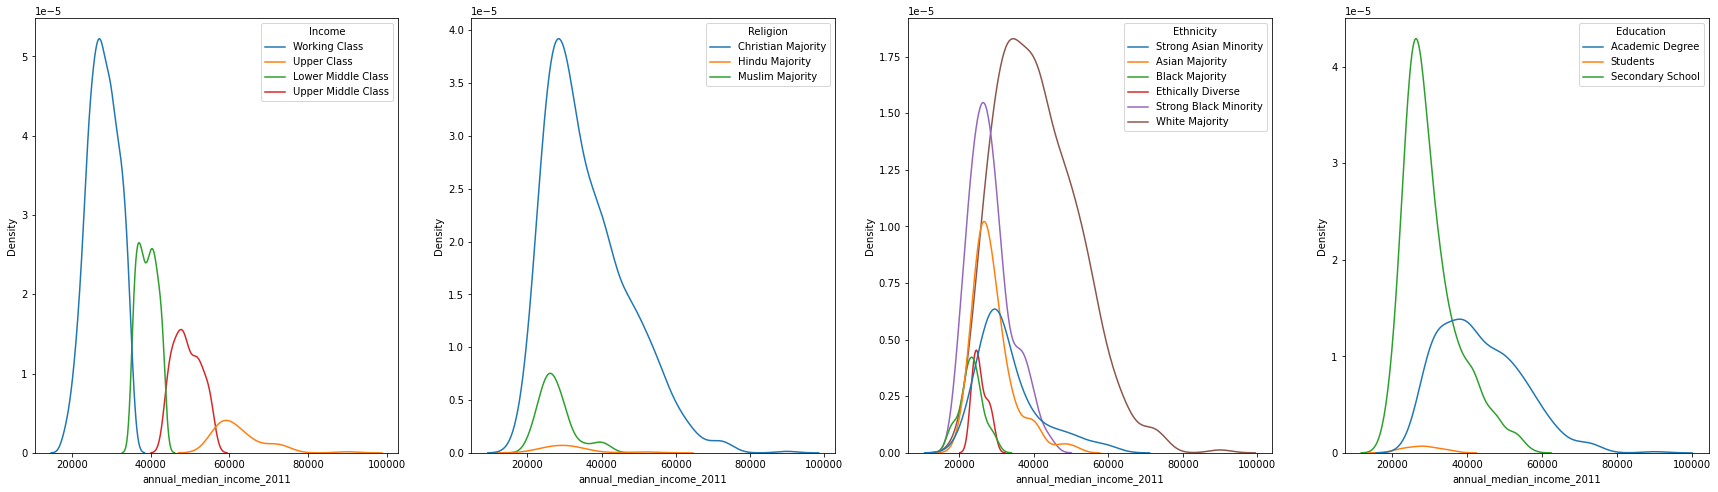

In [120]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (30,8))

sns.kdeplot(data = msoa_social, x = "annual_median_income_2011", hue = "Income", ax = ax1)
sns.kdeplot(data = msoa_social, x = "annual_median_income_2011", hue = "Religion", ax = ax2)
sns.kdeplot(data = msoa_social, x = "annual_median_income_2011", hue = "Ethnicity", ax = ax3)
sns.kdeplot(data = msoa_social, x = "annual_median_income_2011", hue = "Education", ax = ax4)

#### Adding Reverse Dicts, if we need to go back from one representation to the other, but keep consistency

In [121]:
reverse_dict_Ethnicity = {"Strong Black Minority":0, "Asian Majority":1, "Black Majority":2, "Ethically Diverse":3, "Strong Asian Minority":4, "White Majority":5}
reverse_dict_Income = {"Working Class":0, "Upper Class":1, "Lower Middle Class":2, "Upper Middle Class":3}
reverse_dict_Education = {"Academic Degree":0, "Students":1, "Secondary School":2}
reverse_dict_Religion = {"Christian Majority":0, "Hindu Majority":1, "Muslim Majority":2}

#### Adding the Clustered Data to the GeoJson

In [56]:
for x in msoa_dict["features"]:
    x["properties"]["Income"] = msoa_social["Income"].loc[x["id"]]
    x["properties"]["Education"] = msoa_social["Education"].loc[x["id"]]
    x["properties"]["Ethnicity"] = msoa_social["Ethnicity"].loc[x["id"]]
    x["properties"]["Religion"] = msoa_social["Religion"].loc[x["id"]]

#### Testing some Plotting Approaches

In [57]:
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]], vertical_spacing=0.15)
fig.add_trace(go.Pie(labels=msoa_social.groupby(by= "Income").count().index, values=msoa_social.groupby(by= "Income").count()["name"], hole=.3 ,textinfo='label+percent'),1,1)
fig.add_trace(go.Pie(labels=msoa_social.groupby(by= "Ethnicity").count().index, values=msoa_social.groupby(by= "Ethnicity").count()["name"], hole=.3 ,textinfo='label+percent'),1,2)
fig.add_trace(go.Pie(labels=msoa_social.groupby(by= "Religion").count().index, values=msoa_social.groupby(by= "Religion").count()["name"], hole=.3,textinfo='label+percent'),2,1)
fig.add_trace(go.Pie(labels=msoa_social.groupby(by= "Education").count().index, values=msoa_social.groupby(by= "Education").count()["name"], hole=.3 ,textinfo='label+percent'),2,2)

fig.update_layout(showlegend = False)

print("Writing HTML to Repo...")
path = "../fierceeagle.github.io/_includes/"+"Donuts_Clusters"+".html"
fig.write_html("../fierceeagle.github.io/_includes/"+"Donuts_Clusters"+".html")
plot_map_inline(path)

Writing HTML to Repo...


In [58]:
msoa_social_sunburst = msoa_social.copy()
msoa_social_sunburst["total"] = "Total"
msoa_social_sunburst = msoa_social_sunburst.groupby(by = ["total","Ethnicity", "Education", "Income"]).count().reset_index()
msoa_social_sunburst = msoa_social_sunburst.dropna()
fig = px.sunburst(msoa_social_sunburst, path=["total","Ethnicity", "Education", "Income"], color = "name",branchvalues  = "total", values='name',color_continuous_scale='RdBu') 
fig.update_traces(insidetextorientation='radial')

path = "../fierceeagle.github.io/_includes/"+"Sunburst_"+".html"
print("Writing HTML to Repo...")
fig.write_html(path)
plot_map_inline(path)

Writing HTML to Repo...


#### Joining the Dataframes

In [123]:
lsoa_unfiltered_year = lsoa_social.join(lsoa_year, how = "inner")
msoa_unfiltered_year = msoa_social.join(msoa_year, how = "inner")
osward_unfiltered_year = osward_social.join(osward_year, how = "inner")

In [124]:
print("Turning the Data into a pickle ... ")

jar = "pickle_jar" 

msoa_unfiltered_year.to_pickle(path = os.path.join(jar,"msoa_unfiltered_year.pkl"))
lsoa_unfiltered_year.to_pickle(path = os.path.join(jar,"lsoa_unfiltered_year.pkl"))
osward_unfiltered_year.to_pickle(path = os.path.join(jar,"ward_unfiltered_year.pkl"))

print("Funniest shit I have ever seen!")

Turning the Data into a pickle ... 
Funniest shit I have ever seen!


#### Filtering Data based on Representativness for all later analysis

In [125]:
# Consider only Areas with atleast 10% Representative-ness:

lsoa_combined_year     = lsoa_unfiltered_year[lsoa_unfiltered_year.representativeness_norm > 0.10]
msoa_combined_year     = msoa_unfiltered_year[msoa_unfiltered_year.representativeness_norm > 0.10]
osward_combined_year    = osward_unfiltered_year[osward_unfiltered_year.representativeness_norm > 0.10]

#### Writing Filtered Data into pkl

In [126]:
msoa_combined_year.to_pickle(path = os.path.join(jar,"msoa_filtered_year.pkl"))
lsoa_combined_year.to_pickle(path = os.path.join(jar,"lsoa_filtered_year.pkl"))
osward_combined_year.to_pickle(path = os.path.join(jar,"ward_filtered_year.pkl"))


#### Taking them out of the Jar again

In [127]:
print("Loading pickled Data")
jar = "pickle_jar" 

osward_combined_year = pd.read_pickle(os.path.join(jar,"ward_filtered_year.pkl"))
msoa_combined_year = pd.read_pickle(os.path.join(jar,"msoa_filtered_year.pkl"))
lsoa_combined_year = pd.read_pickle(os.path.join(jar,"lsoa_filtered_year.pkl"))

Loading pickled Data


### Its about Thyme

For a short look into the data we will look into the caloric consumption based on different nutrients on the ward level during the twelve month measuring period

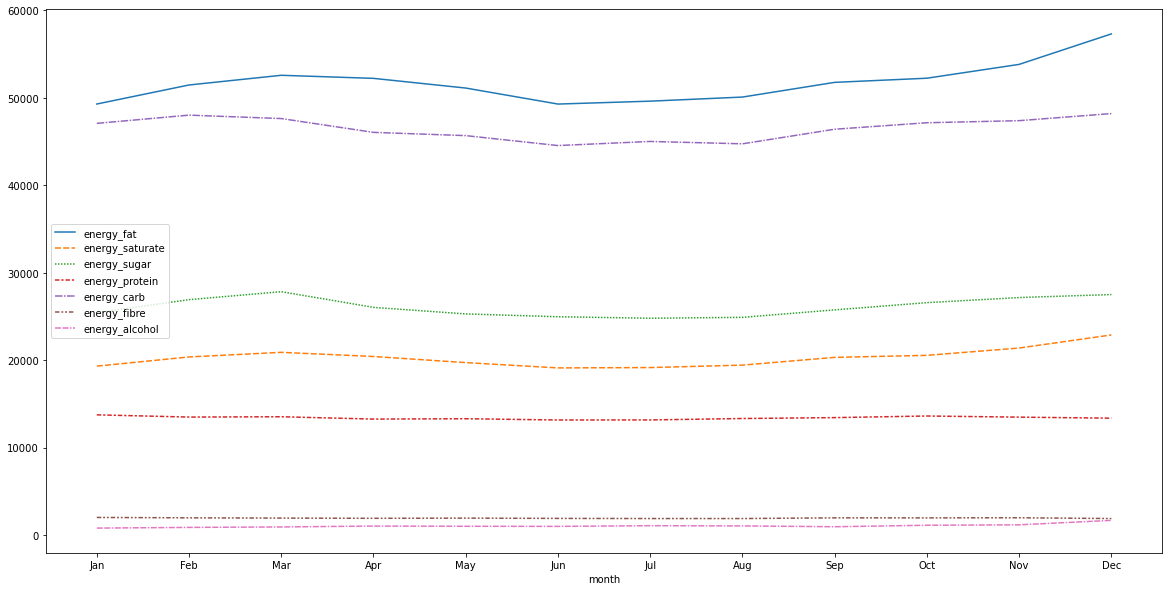

In [128]:
fig, ax = plt.subplots(figsize = (20,10))

g = sns.lineplot(data = osward_months.groupby(by = "month").sum()[nutrients], ax = ax)
plt.show()

#### Barplots for different interesting attributes

#### Entering the 3D Mind Dojo

In [66]:
three_D_plot_factory(dataframe = msoa_combined_year,
                     x_axis ="annual_median_income_2011" ,
                     y_axis = "perc_ethnicity_white_2011",
                     title = "Interaction between Household Income, Ethnicity and Alcohol Consumption",
                     x_title = "White Inhabitants (%)",
                     y_title = "Area Median Income",
                     z_title = "Kcal by Alcohol in AAP",
                     aggfunc = np.mean, 
                     z_axis = "energy_alcohol",
                     html_name = "3D_Plot_White_Median_Income_Alcohol",
                     output_html = True,
                     auto_commit = True ,
                     quantiles = [0,.125,.25,.375,.5, .625,.75,.875,1]
                     )

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus


In [67]:
three_D_multi_plot_factory(
                     dataframe = msoa_combined_year,
                     x_axis  ="annual_median_income_2011" ,
                     y_axis  = "perc_ethnicity_white_2011",
                     title   = "Interaction between Household Income, Ethnicity and Alcoholic Product Consumption",
                     x_title = "White Inhabitants (%)",
                     y_title = "Area Median Income",
                     z_title = "Kcal by Alcohol in AAP",
                     aggfunc = np.mean, 
                     category_z  = ["f_spirits", "f_wine", "f_beer"],
                     html_name   = "3D_Multi_Plot_Test",
                     output_html = True,
                     auto_commit = True,
                     quantiles   = [0,.125,.25,.375,.5, .625,.75,.875,1],
                     )

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus


### GeoViz plots
Generation of the final GeoViz Plots, that can be found on the website, the initial data acqusition and merging is performed in independent Notebooks, also found in the repository, as they have package conflict and were only requiered to run once.  

<a id='GeoViz'></a>

In [68]:
map_plot_factory(msoa_unfiltered_year,
                 geojson=msoa_dict,
                 color_col='Religion',
                 zoom=9,
                 opacity=0.35,
                 labels={'Clustering of Religion on the MSOA Level'},
                 file_name = "Map_Clustering_Religion")

Generating Map ... 
Updating Layout ... 
Writing HTML ...
Creating IFrame ...


#### Did you know that many of Londons Landmark, such as Big Ben, the Parliamnet and Buckinham Palace, are located inside the City of Westminster not the City of London?
Bonus Fact: Big Ben is the Clock inside the Elizabeth Tower of the Parliament not the Tower itself

In [69]:
geo_path = "Geo_Data"

scatter_top_four  = pd.read_csv("Geo_Data/top_four_store_locations_greater_london.csv")
scatter_top_four["size"] = 10
scatter_top_four["Store Name"] = scatter_top_four["BusinessName"]

fig = px.scatter_mapbox(scatter_top_four, lat="Latitude", lon="Longitude", hover_name="BusinessName", mapbox_style="carto-positron",
                        zoom = 10, center = {"lat": 51.509865, "lon": -0.118092},
                        opacity=0.65, 
                        size = "size",
                        color_discrete_map = {"Asda": "#78BE20" ,"Sainsbury" : "#ED8B01", "Morrisons":"#00563F", "Tesco":"#00539F"},
                        size_max = 7,
                        color="Store Name",
                        hover_data={'Store Name':True, # remove species from hover data
                                    'size' : False,
                                    'Latitude':':.2f', # customize hover for column of y attribute
                                    'Longitude':':.2f', # add other column, customized formatting
                                   }
                       
                       )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

path = "../fierceeagle.github.io/_includes/Store_Locations_London.html"

fig.write_html(path)
github_hook()
plot_map_inline(path)

Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus


#### Exploring our Clustering

In [70]:
map_plot_factory(msoa_unfiltered_year,
                 geojson=msoa_dict,
                 color_col='Religion',
                 zoom=9,
                 opacity=0.35,
                 labels={'Clustering of Religion on the MSOA Level'},
                 file_name = "Map_Factory_Test")

Generating Map ... 
Updating Layout ... 
Writing HTML ...
Creating IFrame ...


In [71]:
map_plot_factory(msoa_unfiltered_year,
                 geojson=msoa_dict,
                 color_col='Ethnicity',
                 zoom=9,
                 opacity=0.35,
                 labels={'Clustering of Ethnicity on the MSOA Level'},
                 file_name = "Map_Factory_Test")

Generating Map ... 
Updating Layout ... 
Writing HTML ...
Creating IFrame ...


In [72]:
template = "%{properties.Income}<br>%{properties.Education}<br>%{properties.Ethnicity}<br>%{properties.Religion}<br>"

multilayer_map_plot_factory(msoa_unfiltered_year,
                            geojson=msoa_dict,
                            layers = ["Income","Education", "Ethnicity", "Religion"],
                            zoom=9,
                            opacity=0.65,
                            hovertemplate = template,
                            title = "A Multilayer Plot Test",
                            hook = True,
                            file_name = "Multilayer_Population_Plot")

Generating Map ... 
Updating Layout ... 
Writing HTML ...
Call me Ishmael
Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus
Creating IFrame ...


## Only Proper ML Following from here on out

#### Correlation Analysis
<a id='Stats'></a>

In [73]:
correl = [(group, stats.spearmanr(a = msoa_combined_year["representativeness_norm"], b = msoa_combined_year[group]).correlation) for group in (["annual_median_income_2011"] + ethnicities + education) if stats.spearmanr(a = msoa_combined_year["representativeness_norm"], b = msoa_combined_year[group]).pvalue < 0.05]

fig = go.Figure()
fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] >= 0], y=[c[1] for c in correl if c[1] >= 0],
                    marker_color= color_tesco_blue,
                    name='positives'))

fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] < 0], y=[c[1] for c in correl if c[1] < 0],
                    marker_color= color_tesco_red,
                    name='negatives'))

fig.update_layout(template = "plotly_white", showlegend=False)
path = "../fierceeagle.github.io/_includes/Correlation_Representativness_Norm_White.html"
fig.write_html("../fierceeagle.github.io/_includes/Correlation_Representativness_Norm_White.html")
plot_map_inline(path)

### Some Factorio

In [74]:
bar_plot_factory(dataframe = msoa_combined_year,
                 category_socio_economics = ['perc_ethnicity_white_2011','perc_ethnicity_other_2011','perc_ethnicity_asian_2011','perc_ethnicity_black_2011'],
                 category_nutrion = nutrients,
                 html_name = "Correlation_Nutirents_Different_Ethnicitites",
                 output_html = True,
                 auto_commit = True)

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus


In [75]:
bar_plot_factory(dataframe = msoa_combined_year,
                 category_socio_economics = ['perc_ethnicity_white_2011','perc_ethnicity_bame_2011'],
                 category_nutrion = nutrients,
                 html_name = "Correlation_Nutirents_WhiteAndBAME_Ethnicitites",
                 output_html = True,
                 auto_commit = True)

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Hello, ... Hello, ... Vienna Calling?
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished
Rock me Amadeus


#### Data Analysis Using Regressors 

Look at the interaction of Product and Nutrient Consumption and their Relationship and Predictive power towards factors, such as High Education, Diversity and Income 

In [78]:
log_model_interaction_variable = smf.ols(formula='ethnicity_bame_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     ethnicity_bame_2011   R-squared:                       0.557
Model:                             OLS   Adj. R-squared:                  0.554
Method:                  Least Squares   F-statistic:                     158.0
Date:                 Wed, 02 Dec 2020   Prob (F-statistic):          1.12e-150
Time:                         17:18:30   Log-Likelihood:                -7573.7
No. Observations:                  886   AIC:                         1.516e+04
Df Residuals:                      878   BIC:                         1.520e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.512e+04   172

In [79]:
log_model_interaction_variable = smf.ols(formula='annual_median_income_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     annual_median_income_2011   R-squared:                       0.604
Model:                                   OLS   Adj. R-squared:                  0.601
Method:                        Least Squares   F-statistic:                     191.6
Date:                       Wed, 02 Dec 2020   Prob (F-statistic):          5.99e-172
Time:                               17:18:39   Log-Likelihood:                -9077.5
No. Observations:                        886   AIC:                         1.817e+04
Df Residuals:                            878   BIC:                         1.821e+04
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Ensemble Model Classfiers/Regressors 
<a id='Ensemble'></a>
Consider Random Forest vs. Boosting Trees. Perform Model Selection for Hyperparameters 

In [80]:
X = msoa_combined_year[nutrients]
y = msoa_combined_year['annual_median_income_2011']
n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

    
for x in tqdm(it.product(n_estimators,max_features)): 
    
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:06,  6.49s/it]

0.5551755115973317

 (75, 'sqrt')


2it [00:07,  4.85s/it]

0.5529230782946672

 (100, 'auto')


3it [00:09,  4.09s/it]

0.5575288612138547

 (100, 'sqrt')


4it [00:11,  3.37s/it]

0.5615736931133039

 (200, 'auto')


5it [00:16,  3.82s/it]

0.5601449302897177

 (200, 'sqrt')


6it [00:20,  3.76s/it]

0.5670017567563019

 (250, 'auto')


7it [00:27,  4.73s/it]

0.5594830895849232

 (250, 'sqrt')


8it [00:30,  3.76s/it]

0.5652958133765351


In [81]:
X = msoa_combined_year[nutrients]
y = msoa_combined_year['annual_median_income_2011']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  3.92it/s]

0.5057182180291274

 (20, 0.05)


2it [00:00,  4.06it/s]

0.5107720327453519

 (20, 0.01)
0.5146116645007767

3it [00:00,  4.31it/s]



 (50, 0.1)


4it [00:01,  3.49it/s]

0.4887433192831513

 (50, 0.05)


5it [00:01,  3.03it/s]

0.5027572697174298

 (50, 0.01)


6it [00:01,  2.83it/s]

0.5109676732918393

 (100, 0.1)


7it [00:02,  2.46it/s]

0.4849804233460743

 (100, 0.05)


8it [00:03,  2.06it/s]

0.49312383813420163

 (100, 0.01)


9it [00:03,  1.86it/s]

0.5105042444578929

 (200, 0.1)


10it [00:04,  1.84it/s]

0.48314080898634015

 (200, 0.05)


11it [00:05,  1.44it/s]

0.48661687641550555

 (200, 0.01)


12it [00:06,  1.08it/s]

0.5052639700423832

 (250, 0.1)


13it [00:07,  1.19it/s]

0.4856663059836855

 (250, 0.05)


14it [00:08,  1.07it/s]

0.48636944405110666

 (250, 0.01)


15it [00:10,  1.41it/s]

0.5014753085131806


In [82]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(msoa_combined_year[nutrients], msoa_combined_year['annual_median_income_2011'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


0.6315263874089777

#### "Explainable" Decision Tree Model 
<a id='>DecisionTree'></a>
Try to train a model that can provide good performance on a testing set and additonally an understandable decision tree, at least on a higher level understanding. 

#### Predicting Ethnicity based on Nutrient consumption

Best GridSeach Score:  0.6296019900497513 Best Parameter Combination:  {'ccp_alpha': 0.0085, 'max_features': 'log2', 'min_samples_split': 18}
0.6891891891891891


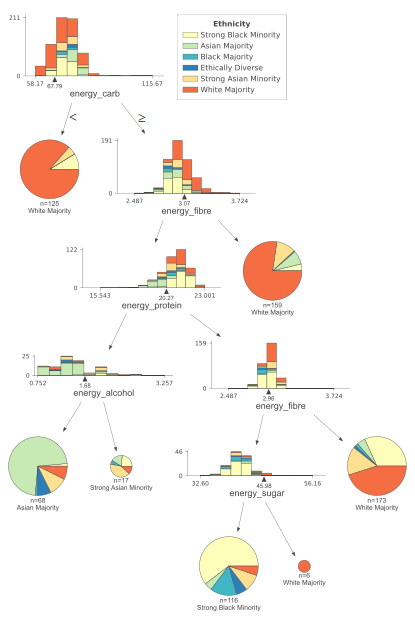

In [210]:
train_x, test_x, train_y, test_y = train_test_split(msoa_combined_year[nutrients], msoa_combined_year['Ethnicity'], random_state=0) 

clf, score, alpha = post_pruning_decision_tree_selector(train_x, train_y, cv = 10,  parameters = {'ccp_alpha':np.arange(0.001, 0.01, 0.0005), "max_features": ["log2", "sqrt", None], "min_samples_split" :np.arange(2,20, 4)})

# Training on the Full Data and Validating it on the Test Set
clf = clf.fit(train_x, train_y)
print(clf.score(test_x, test_y))

# A Visualization of the Decision Tree
tree_plot_factory(train_x, train_y, nutrients, "Ethnicity", clf, reverse_dict_Ethnicity)

#### Predicting Education based on Nutirent consumption

C:\Users\49171\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 6 members, which is less than n_splits=30.



Best GridSeach Score:  0.8735177865612648 Best Parameter Combination:  {'ccp_alpha': 0.004, 'max_features': None, 'min_samples_split': 18}
0.8513513513513513


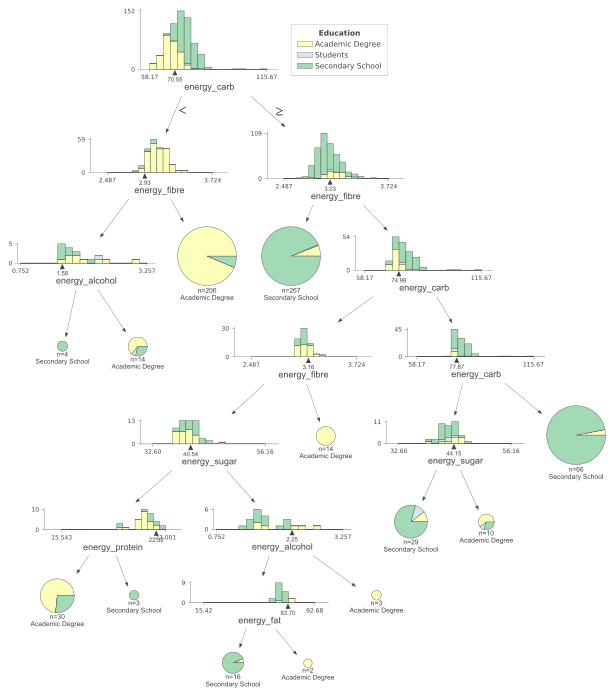

In [217]:
train_x, test_x, train_y, test_y = train_test_split(msoa_combined_year[nutrients], msoa_combined_year['Education'], random_state=0) 

clf, score, alpha = post_pruning_decision_tree_selector(train_x, train_y, cv = 30,  parameters = {'ccp_alpha':np.arange(0.001, 0.01, 0.0005), "max_features": ["log2", "sqrt", None], "min_samples_split" :np.arange(2,20, 4)})

# Training on the Full Data and Validating it on the Test Set
clf = clf.fit(train_x, train_y)
print(clf.score(test_x, test_y))

# A Visualization of the Decision Tree
tree_plot_factory(train_x, train_y, nutrients, "Education", clf, reverse_dict_Education)

#### Learning Rules that allows us to explore Interrelations between interactions
<a id='AssociationRule'></a>

We use the discretization based on the clustering to analyse frequently found commonalities between nutrient consumption and socio-economic make-up of an area founding on frequent item set and association rule mining. 

In [218]:
msoa_combined_items = msoa_combined_year[products].copy()
msoa_combined_items.columns = [x.split("_")[1] for x in products]
cleaned_names = [x.split("_")[1] for x in products]

# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    
msoa_combined_items = msoa_combined_items.join(pd.get_dummies(msoa_social[["Education","Ethnicity","Religion","Income"]]).applymap(lambda x: True if x == 1 else False))

In [219]:
print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.1, use_colnames = True)


# Use Association Rules as an "explainable" Model

cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)
print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'lift', min_threshold = 3)
print("Cleaning Rule Set for desiered Rules ...")
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3342,"(soft_Low, sweets_Low, grains_Low)","(Religion_Christian Majority, fruit_High)",0.120767,0.246050,0.120767,1.000000,4.064220,0.091053,inf
3736,"(soft_Low, water_Low, sweets_Low)","(Religion_Christian Majority, fruit_High)",0.104966,0.246050,0.103837,0.989247,4.020519,0.078011,70.117381
1728,"(water_Low, sweets_Low)","(Religion_Christian Majority, fruit_High)",0.115124,0.246050,0.112867,0.980392,3.984530,0.084541,38.451467
4906,"(soft_Low, sweets_Low, grains_Low)","(Education_Academic Degree, Religion_Christian...",0.120767,0.221219,0.117381,0.971963,4.393668,0.090665,27.776524
3289,"(soft_Low, sweets_Low, grains_Low)","(Education_Academic Degree, fruit_High)",0.120767,0.224605,0.117381,0.971963,4.327432,0.090257,27.655756
5268,"(soft_Low, water_Low, sweets_Low)","(Education_Academic Degree, Religion_Christian...",0.104966,0.221219,0.101580,0.967742,4.374589,0.078360,24.142212
4101,"(water_Low, wine_High, fruit_High)","(Education_Academic Degree, Ethnicity_White Ma...",0.104966,0.279910,0.101580,0.967742,3.457336,0.072199,22.322799
3686,"(soft_Low, water_Low, sweets_Low)","(Education_Academic Degree, fruit_High)",0.104966,0.224605,0.101580,0.967742,4.308640,0.078004,24.037246
5612,"(water_Low, wine_High, fruit_High)","(Education_Academic Degree, Religion_Christian...",0.104966,0.279910,0.101580,0.967742,3.457336,0.072199,22.322799
1625,"(soft_Low, sweets_Low)","(Religion_Christian Majority, fruit_High)",0.145598,0.246050,0.139955,0.961240,3.906692,0.104130,19.451919


In [223]:
rules = rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(5)
rules["antecedents"] = rules.apply(lambda x: ''.join([label_processor(x).capitalize() + "<br>" for x in list(x["antecedents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8") , axis = 1)
rules["consequents"] = rules.apply(lambda x: ''.join([label_processor(x).capitalize() + "<br>" for x in list(x["consequents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8").replace("_", " "), axis = 1)
rules[["support","confidence", "lift"]] = rules[["support","confidence", "lift"]].applymap(lambda x : round(x,3))
rules = rules[["antecedents", "consequents", "support","confidence", "lift"]]
fig = ff.create_table(rules, height_constant=60)

path = "../fierceeagle.github.io/_includes/AssociationRuleTable_Nutrients.html"
fig.write_html(path)
plot_map_inline(path)

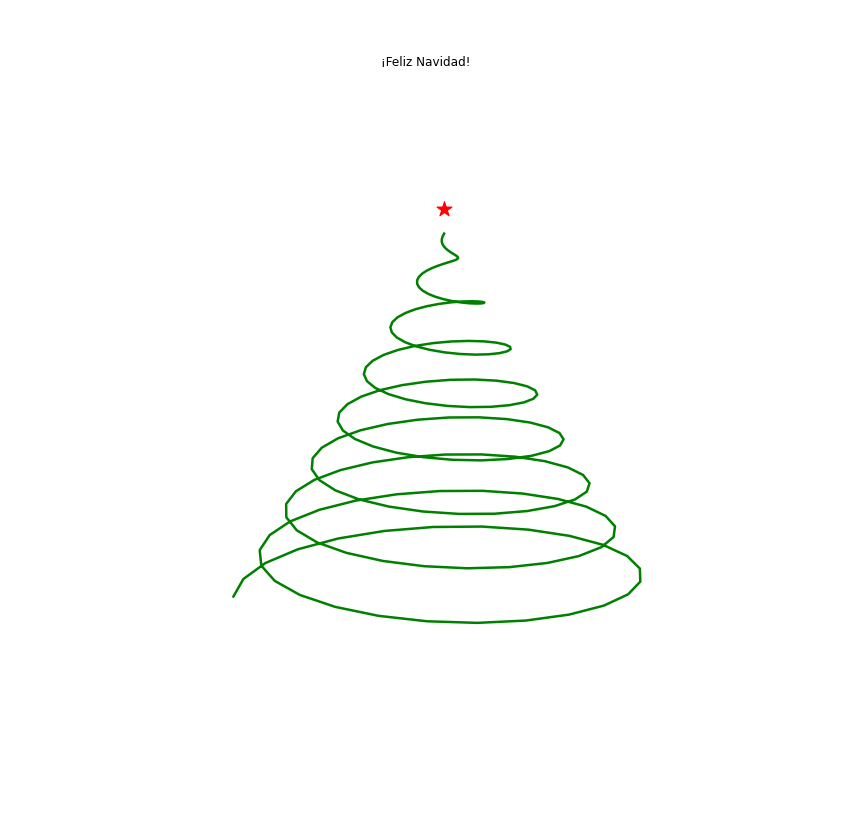

In [221]:
# Calculate spiral coordinates for the Xmas tree
theta = np.linspace(-8 * np.pi, 8 * np.pi, 200) 
z = np.linspace(-3, 0, 200)
r = 5
x = r * np.sin(theta)*z
y = r * np.cos(theta)*z
 
# Use matplotib and its OOP interface to draw it 
fig = plt.figure(figsize  = (15,15)) # Create figure
fig.set
ax = fig.gca(projection='3d') # It's a 3D Xmas tree!
ax.view_init(15, 0) # Set a nice view angle
ax._axis3don = False # Hide the 3d axes
 
# Plot the Xmas tree as a line
ax.plot(x, y, z,
        c='green', linewidth=2.5)
 
# Every Xmas tree needs a star
ax.scatter(0, 0, 0.2,
           c='red', s=250, marker='*')
 
# Type here your best whishes
ax.set_title(u"¡Feliz Navidad!")
 
plt.show()